<a href="https://colab.research.google.com/github/zubairwazir/Responsive-Protfolio-Website/blob/master/CartPole_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Reinforcement Learning Intern Position (Neurog)


---







## Assessment Task by ***Zubair Ahmad***

---



# Deep Q-learning

In this notebook, I will build a neural network that can learn to play games through reinforcement learning. More specifically, I will use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.


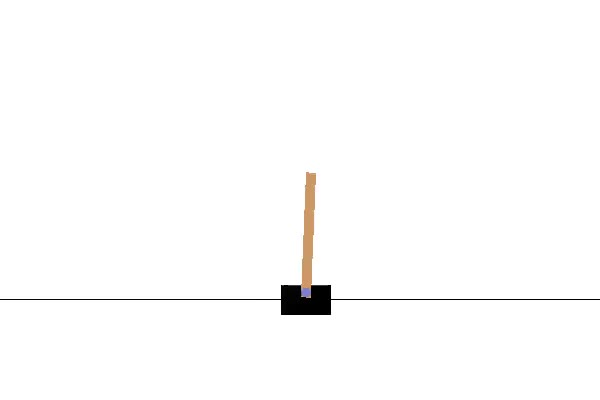


A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical,or the cart moves more than 2.4 units from the center.


I will simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, I will get into training an agent to play the Cart-Pole game.

## Importing Libraries

In [ ]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np

# Create the Cart-Pole game environment


> Environment name: *CartPole-v0* 







In [ ]:
env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only tuning the network, but it tuning the simulation.

In [ ]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.epsilon_decay = .995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_space,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Deep Q-Learning training algorithm

Putting all this together, we can list out the algorithm I will use to train the network. I Will train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

In [ ]:
def train_dqn(episode):

    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 4))
        score = 0
        max_steps = 1000
        for i in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 4))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)
    return loss

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network’s goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [ ]:
def random_policy(episode, step):

    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")


## Training

Below I will train our agent. 

## Visualizing training

I will also plot the total rewards for each episode.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode: 0/100, score: 12.0
episode: 1/100, score: 15.0
episode: 2/100, score: 19.0
episode: 3/100, score: 17.0
episode: 4/100, score: 13.0
episode: 5/100, score: 15.0
episode: 6/100, score: 21.0
episode: 7/100, score: 12.0
episode: 8/100, score: 40.0
episode: 9/100, score: 10.0
episode: 10/100, score: 15.0
episode: 11/100, score: 23.0
episode: 12/100, score: 11.0
episode: 13/100, score: 16.0
episode: 14/100, score: 11.0
episode: 15/100, score: 12.0
episode: 16/100, score: 9.0
episode: 17/100, score: 13.0
episode: 18/100, score: 10.0
episode: 19/100, score: 10.0
episode: 20/100, score: 12.0
episode: 21/100, score: 13.0
episode: 22/100, score: 12.0
episode: 23/100, score: 27.0
episode: 24/100, score: 19.0
episode: 25/100, score: 41.0
episode: 26/100, score: 38.0
episode: 27/100, score: 27.0
episode: 28/100, score: 68.0
episode: 29/100, score: 74.0
episode: 30/100, score: 107.0
episode: 31/100, score: 105.0
episode: 32/100, score: 130.0
episode: 33/100, score: 118.0
episode: 34/100, scor

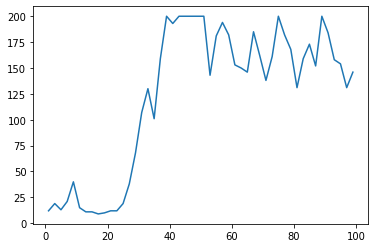

In [ ]:
if __name__ == '__main__':

    ep = 100
    loss = train_dqn(ep)
    plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
    plt.show()